In [10]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns
import datetime as dt
import os, sys, time, asyncio, re
import functools

# Set path
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
# from common.functions import portstats_bm

In [17]:
# .h5 files... don't work...
# pd.read_hdf("../data/2021/Full_Size_Parsed_HDF5/2021-04__ETH-BTC_orders.h5")

DATADIR = "../data/2021/For_Homework/"

books, trades = {}, {}

for filename in os.listdir(DATADIR):
    pair = re.findall(r'[A-Z]{3}-[A-Z]{3}', filename)[0]
    
    if filename[:6]=="trades":
        trades[pair] = pd.read_csv(DATADIR + filename, compression="gzip", sep='\t')
    elif filename[:4]=="book":
        pass
    else:
        print(f"Not reading {filename}")

In [19]:
trades["ETH-BTC"]

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090137140737000,1618090137157544000,35690,1000000,-1
1,1618090137851379000,1618090137864544000,35700,29801980,2
2,1618090143777062000,1618090143793909000,35700,4641070,1
3,1618090155038792000,1618090155053606000,35710,1000000,1
4,1618090155039208000,1618090155053606000,35720,231355690,1
...,...,...,...,...,...
32739,1618270609444614000,1618270609550910000,35780,6917960,1
32740,1618270609827303000,1618270609930738000,35780,182922480,1
32741,1618270610376143000,1618270610482336000,35780,4577180,1
32742,1618270615253262000,1618270615358639000,35760,2926932560,-1


In [72]:
trd_raw = trades["ETH-BTC"]
trd_raw

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1618090137140737000,1618090137157544000,35690,1000000,-1
1,1618090137851379000,1618090137864544000,35700,29801980,2
2,1618090143777062000,1618090143793909000,35700,4641070,1
3,1618090155038792000,1618090155053606000,35710,1000000,1
4,1618090155039208000,1618090155053606000,35720,231355690,1
...,...,...,...,...,...
32739,1618270609444614000,1618270609550910000,35780,6917960,1
32740,1618270609827303000,1618270609930738000,35780,182922480,1
32741,1618270610376143000,1618270610482336000,35780,4577180,1
32742,1618270615253262000,1618270615358639000,35760,2926932560,-1


In [73]:
trd_raw = trd_raw.iloc[:100,:]
trd_raw.loc[:, "dflow"] = (trd_raw["SizeBillionths"] * (trd_raw["Side"] > 0) 
                    - trd_raw["SizeBillionths"] * (trd_raw["Side"] < 0))

trd_raw = trd_raw.set_index("timestamp_utc_nanoseconds")["dflow"]
orig = trd_raw.cumsum()
orig

/tmp/ipykernel_27972/1949860180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trd_raw.loc[:, "dflow"] = (trd_raw["SizeBillionths"] * (trd_raw["Side"] > 0)


timestamp_utc_nanoseconds
1618090137157544000       -1000000
1618090137864544000       28801980
1618090143793909000       33443050
1618090155053606000       34443050
1618090155053606000      265798740
                          ...     
1618090539008201000    31557401420
1618090552931032000    31510028150
1618090553938374000    31512690020
1618090559325968000    31515077870
1618090561068317000    31517383380
Name: dflow, Length: 100, dtype: int64

<AxesSubplot:xlabel='timestamp_utc_nanoseconds'>

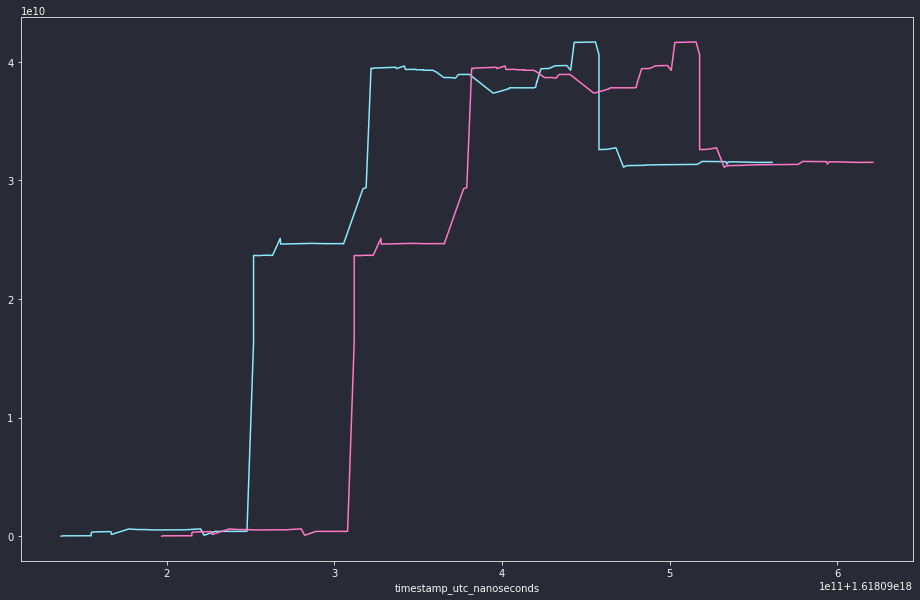

In [74]:
tshi = orig.copy(deep=True)

tshi.index += 60*1e9 # 10 sec
orig.plot()
tshi.plot()

In [77]:
tshi.name = "new"

unholy = pd.concat([orig.to_frame("orig"), tshi.to_frame("new")], axis=0)
unholy
# unholy.sort_index(inplace=True)
# unholy.fillna(method="ffill", inplace=True)

# unholy.loc[orig.index,:].plot()

,orig,new
timestamp_utc_nanoseconds,,
1618090137157543936.0000,-1000000.0000,NaN
1618090137864544000.0000,28801980.0000,NaN
1618090143793908992.0000,33443050.0000,NaN
1618090155053605888.0000,34443050.0000,NaN
1618090155053605888.0000,265798740.0000,NaN
...,...,...
1618090599008200960.0000,NaN,31557401420.0000
1618090612931032064.0000,NaN,31510028150.0000
1618090613938373888.0000,NaN,31512690020.0000


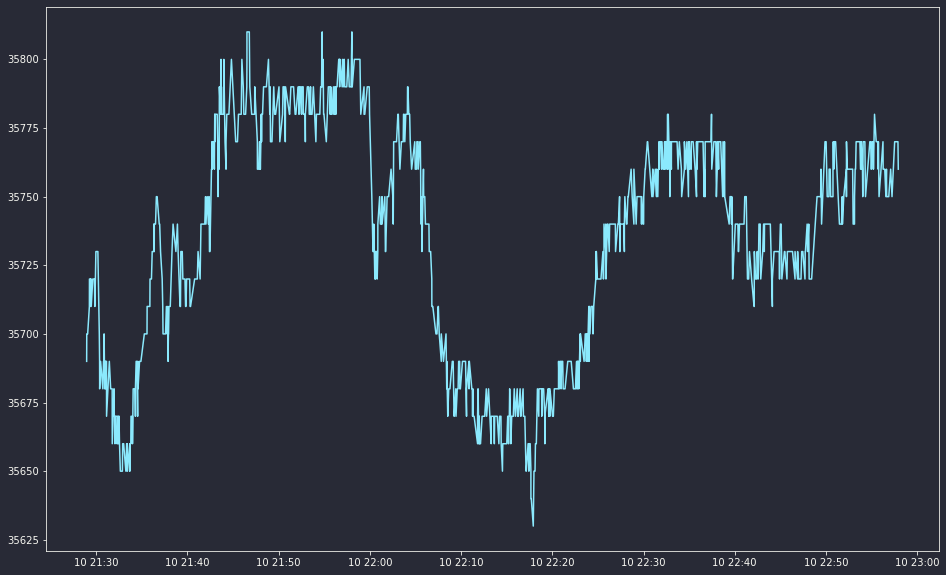

In [21]:
plot_df = trd_raw.iloc[:1000,:]

plt.plot(pd.to_datetime(plot_df["timestamp_utc_nanoseconds"]), plot_df["PriceMillionths"])
plt.show()

<AxesSubplot:ylabel='Frequency'>

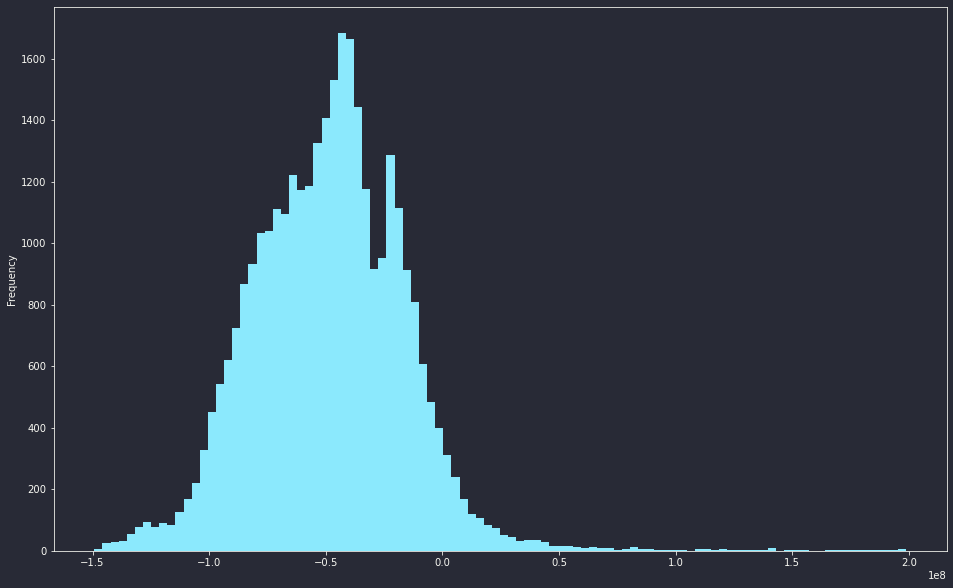

In [23]:
latency = (trd_raw["received_utc_nanoseconds"] - trd_raw["timestamp_utc_nanoseconds"])
latency[np.abs(latency)<2e8].plot.hist(bins=100)
plt.show()

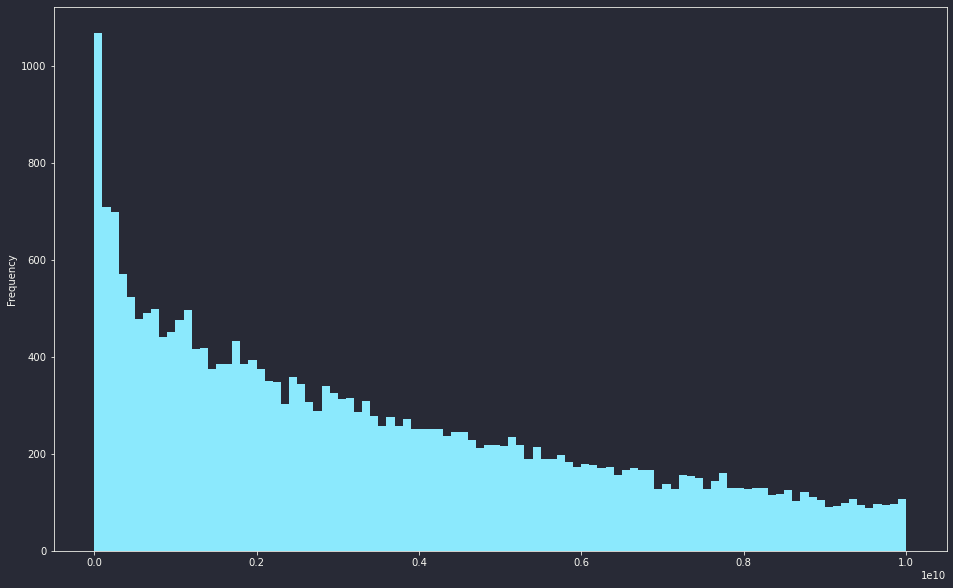

In [49]:
dt = trd_raw["timestamp_utc_nanoseconds"].diff()

dt[(0<dt) & (dt<1e10)].plot.hist(bins=100)
plt.show()